In [77]:
import requests
import geopandas as gpd
import pandas as pd
import contextily as cx
import pprint

from gtts import gTTS
import os
from playsound import playsound

In [78]:
#get user location - I'm just doing this manually for now
def get_loc():
    lat, lon = 40.674915855736494, -73.98109773433283
    loc = gpd.points_from_xy([-73.98109773433283], [40.674915855736494]) #create geometry
    loc_df = gpd.GeoDataFrame({'col1': ['current_location']},geometry = loc) #make a geodataframe with current location
    coord = f'{lat}|{lon}' #reformat coord as string for wiki api geosearch
    return loc_df, coord

In [79]:
#get nearby wiki pages based on output of get_loc() function
def get_nearby(loc_df, coord):
    S = requests.Session()

    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "format": "json",
        "list": "geosearch",
        "gscoord": coord,
        "gslimit": "10",
        "gsradius": "10000",
        "action": "query"
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()

    #create a geodataframe with the query results and convert lat-long values into geometry
    near_df = gpd.GeoDataFrame(DATA['query']['geosearch'])
    near_df = gpd.GeoDataFrame(near_df,geometry=gpd.points_from_xy(near_df.lon, near_df.lat), crs='EPSG:4326')

    #plot the nearby points
    ax = near_df.plot(figsize = (10,10), label = near_df.title)
    minx, miny, maxx, maxy = near_df.total_bounds
    loc_df.plot(ax = ax)
    ax.set_xlim(minx-.01, maxx+.01)
    ax.set_ylim(miny-.01, maxy+.01)
    cx.add_basemap(ax, zoom = 15,crs = near_df.crs)

    return near_df

C:\Users\Gabriel\anaconda3\envs\ADS2\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
C:\Users\Gabriel\anaconda3\envs\ADS2\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,pageid,ns,title,lat,lon,dist,primary,geometry
0,21257186,0,Union Street station (BMT Fifth Avenue Line),40.676408,-73.980464,174.4,,POINT (-73.98046 40.67641)
1,31002362,0,Public Bath No. 7,40.676667,-73.983333,271.0,,POINT (-73.98333 40.67667)
2,21257209,0,Third Street station (BMT Fifth Avenue Line),40.672789,-73.983292,300.3,,POINT (-73.98329 40.67279)
3,2200217,0,Union Street station (BMT Fourth Avenue Line),40.677222,-73.983056,305.0,,POINT (-73.98306 40.67722)
4,9453923,0,Park Slope Food Coop,40.674853,-73.976881,355.7,,POINT (-73.97688 40.67485)
5,434124,0,Old Stone House (Brooklyn),40.672958,-73.984625,368.6,,POINT (-73.98462 40.67296)
6,63275706,0,Washington Park (Brooklyn),40.673000,-73.985000,392.0,,POINT (-73.98500 40.67300)
7,771072,0,Washington Park (baseball),40.673972,-73.985722,403.9,,POINT (-73.98572 40.67397)
8,25421115,0,Old First Reformed Church (Brooklyn),40.673333,-73.976389,434.4,,POINT (-73.97639 40.67333)
9,52333155,0,Community Bookstore (Park Slope),40.672673,-73.976437,465.5,,POINT (-73.97644 40.67267)


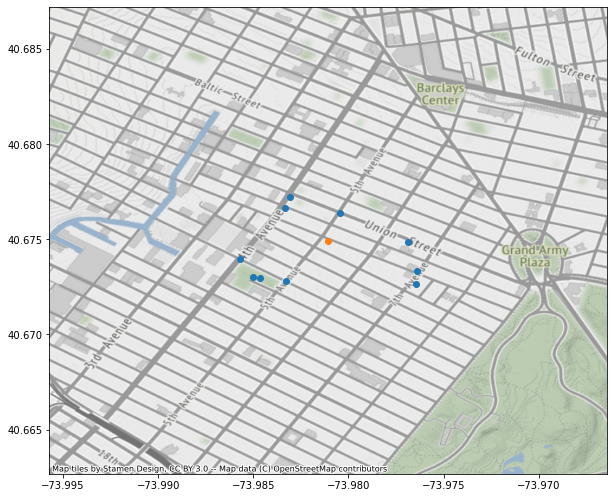

In [80]:
loc_df, coord = get_loc()
near_df = get_nearby(loc_df, coord)
near_df

In [82]:
def get_wikiContent(near_df):
    texts = []
    for index, row in near_df.iterrows():        
        title = row['title']
        pageid = row['pageid']
    
        S = requests.Session()

        URL = "https://en.wikipedia.org/w/api.php"
        
        PARAMS = {
            "action":"query",
            "prop":"extracts",
            "exlimit":1,
            "titles":title,
            "explaintext":1,
            "format":"json"
            
        }

        R = S.get(url=URL, params=PARAMS)
        DATA = R.json()

        #extract the text from the json object
        text = DATA['query']['pages'][str(pageid)]['extract']

        texts.append(text)

    near_df['text'] = texts


In [84]:
get_wikiContent(near_df)
near_df

,pageid,ns,title,lat,lon,dist,primary,geometry,text
0,21257186,0,Union Street station (BMT Fifth Avenue Line),40.676408,-73.980464,174.4,,POINT (-73.98046 40.67641),Union Street was a station on the demolished s...
1,31002362,0,Public Bath No. 7,40.676667,-73.983333,271.0,,POINT (-73.98333 40.67667),Public Bath No. 7 is a historic bathhouse loca...
2,21257209,0,Third Street station (BMT Fifth Avenue Line),40.672789,-73.983292,300.3,,POINT (-73.98329 40.67279),Third Street was a station on the demolished s...
3,2200217,0,Union Street station (BMT Fourth Avenue Line),40.677222,-73.983056,305.0,,POINT (-73.98306 40.67722),The Union Street station is a local station on...
4,9453923,0,Park Slope Food Coop,40.674853,-73.976881,355.7,,POINT (-73.97688 40.67485),The Park Slope Food Coop (PSFC) is a food coop...
5,434124,0,Old Stone House (Brooklyn),40.672958,-73.984625,368.6,,POINT (-73.98462 40.67296),The Old Stone House is a house located in the ...
6,63275706,0,Washington Park (Brooklyn),40.673000,-73.985000,392.0,,POINT (-73.98500 40.67300),Washington Park is a city owned and operated p...
7,771072,0,Washington Park (baseball),40.673972,-73.985722,403.9,,POINT (-73.98572 40.67397),Washington Park was the name given to three Ma...
8,25421115,0,Old First Reformed Church (Brooklyn),40.673333,-73.976389,434.4,,POINT (-73.97639 40.67333),"The Old First Reformed Church in Brooklyn, New..."
9,52333155,0,Community Bookstore (Park Slope),40.672673,-73.976437,465.5,,POINT (-73.97644 40.67267),Community Bookstore is a bookstore in the Park...


In [85]:
#play the audio of one of the wiki pages. i determines which one
def play_text(near_df,i):
    t = near_df['text'][i]
    pid = near_df['pageid'][i]
    #use Google text-to-speech to create an mp3 object
    mp3 = gTTS(text = t, lang = 'en', slow = False)
    mp3.save(f'{pid}.mp3')
    #play the mp3
    playsound(f'{pid}.mp3')
    #delete the mp3 file after finished playing
    os.remove(f'{pid}.mp3')

In [86]:
play_text(near_df, 8)